In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import rpy2

import numpy as np
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
rpy2.robjects.numpy2ri.activate()

stats = importr('stats')

In [6]:
order = pd.read_csv('~/Desktop/coursework/data/stage4/sorted_inno_sp.csv')
order = order.rename(columns = {'VGL ID':'sp2'})
order.head()

,TotInno_resResEff2022,sp2
0,1.974601,bHirRus1
1,1.950304,bAquChr1
2,1.565219,bCorMon1
3,1.445271,bEriRub2
4,1.357739,bSteHir1


In [7]:
df = pd.read_csv('~/Desktop/coursework/data/stage4/chrom_int_anno.csv')
df['file_name'] = '../chrom_int/'+df['chrom'].astype(str)+'_'+df['start'].astype(str)+'.tsv'
df.shape

(6890, 15)

In [9]:
pvals = pd.read_csv('~/Desktop/coursework/data/stage4/ans_final.csv')
pvals = pvals.T.reset_index(drop=True).rename(columns = {0:'p-values'})

df_new = df.join(pvals)
df_new[df_new['p-values']<=0.05]

df_new['p_adjust'] = pd.Series(list(stats.p_adjust(FloatVector(df_new['p-values']), method = 'BH')))


df_new.to_csv('/Users/aleksandradenisova/Desktop/coursework/data/stage4/positions_with_p_val_phylo.csv', index = False)

In [10]:
df_p = pd.read_csv('/Users/aleksandradenisova/Desktop/coursework/data/stage4/positions_with_p_val_phylo.csv')
df_p = df_p[df_p['p_adjust']<0.05]
df_p.head()

,start,cons,inno,non_inno,REF_inno,ALT_noninno,n_inno,n_noninno,n_all,inno_N,inno_-,noninno_N,noninno_-,chrom,file_name,p-values,p_adjust
1,123675,False,False,False,"A,T,C","T,C",8.0,29.0,37.0,0.0,0.0,0.0,0.0,NC_044211.2,../chrom_int/NC_044211.2_123675.tsv,0.002,0.033857
7,544930,False,False,False,"A,T,C",T,5.0,21.0,26.0,0.0,1.0,0.0,2.0,NC_044211.2,../chrom_int/NC_044211.2_544930.tsv,0.002,0.033857
18,2727693,False,False,False,"G,C","A,G",8.0,25.0,33.0,0.0,0.0,0.0,2.0,NC_044211.2,../chrom_int/NC_044211.2_2727693.tsv,0.001,0.023199
19,2760306,False,False,False,"A,T,G,C","T,C",7.0,26.0,33.0,0.0,1.0,0.0,2.0,NC_044211.2,../chrom_int/NC_044211.2_2760306.tsv,0.001,0.023199
41,5048550,False,False,False,A,"A,G",7.0,24.0,31.0,0.0,1.0,0.0,0.0,NC_044211.2,../chrom_int/NC_044211.2_5048550.tsv,0.003,0.043333


In [12]:
file_name = df_p['file_name'].iloc[4]

def get_zibra(file_name):
    
    df_sp = pd.read_csv('~/Desktop/coursework/data/stage4/{}'.format(file_name[3:]), sep = '\t')
    df_sp['sp2'] = df_sp['sp'].apply(lambda x: x.split('_')[1])
    df_for_plot = order.merge(df_sp, on = 'sp2')
    df_for_plot = df_for_plot[df_for_plot['canon']!='-']
    df_for_plot['Bin_inno']  = df_for_plot['TotInno_resResEff2022'].apply(lambda x: 1 if x>0.5 else 0)
    df_for_plot['inno'] = df_for_plot['Bin_inno'].apply(lambda x: 'innovative' if x==1 else 'non-innovative')

    df_for_plot['Measure of innovation, residuals'] = df_for_plot['TotInno_resResEff2022']
    df_for_plot['Nucleotide'] = df_for_plot['canon']

    zibra = df_for_plot[df_for_plot['sp2']=='bTaeGut1']['canon'].item()

    inno_ = ','.join(df_for_plot[df_for_plot['Bin_inno']==1]['canon'].unique().tolist())

    non_inno_ = ','.join(df_for_plot[(df_for_plot['sp2']!='bTaeGut1') &
                            (df_for_plot['Bin_inno']==0)]['canon'].unique().tolist())

    return zibra, inno_, non_inno_


df_p['ans'] = df_p['file_name'].apply(lambda x: get_zibra(x))

df_p['zibra'] = df_p['ans'].apply(lambda x: x[0])
df_p['inno_'] = df_p['ans'].apply(lambda x: x[1])
df_p['non_inno_'] = df_p['ans'].apply(lambda x: x[2])
df_p = df_p.drop(columns = 'ans')

df_p.head()

,start,cons,inno,non_inno,REF_inno,ALT_noninno,n_inno,n_noninno,n_all,inno_N,inno_-,noninno_N,noninno_-,chrom,file_name,p-values,p_adjust,zibra,inno_,non_inno_
1,123675,False,False,False,"A,T,C","T,C",8.0,29.0,37.0,0.0,0.0,0.0,0.0,NC_044211.2,../chrom_int/NC_044211.2_123675.tsv,0.002,0.033857,T,"T,C,A","T,C"
7,544930,False,False,False,"A,T,C",T,5.0,21.0,26.0,0.0,1.0,0.0,2.0,NC_044211.2,../chrom_int/NC_044211.2_544930.tsv,0.002,0.033857,T,"T,C,A",T
18,2727693,False,False,False,"G,C","A,G",8.0,25.0,33.0,0.0,0.0,0.0,2.0,NC_044211.2,../chrom_int/NC_044211.2_2727693.tsv,0.001,0.023199,A,"G,C","A,G"
19,2760306,False,False,False,"A,T,G,C","T,C",7.0,26.0,33.0,0.0,1.0,0.0,2.0,NC_044211.2,../chrom_int/NC_044211.2_2760306.tsv,0.001,0.023199,T,"T,G,C,A",T
41,5048550,False,False,False,A,"A,G",7.0,24.0,31.0,0.0,1.0,0.0,0.0,NC_044211.2,../chrom_int/NC_044211.2_5048550.tsv,0.003,0.043333,G,A,"A,G"


In [13]:
df_p.to_csv('/Users/aleksandradenisova/Desktop/coursework/data/stage4/positions_with_p_val_phylo_zibra.csv', 
            index = False)

In [15]:
df = pd.read_csv('~/Desktop/coursework/data/stage2/chroms_zebra.tsv', sep = '\t')[:-1]

df['Molecule name'] = df['Molecule name'].apply(lambda x: x.split()[1])
df1 = df[['RefSeq sequence', 'Molecule name']].rename(columns= {'RefSeq sequence':'chrom'})
df1.head()

,chrom,Molecule name
0,NC_044211.2,1
1,NC_044212.2,1A
2,NC_044213.2,2
3,NC_044214.2,3
4,NC_044215.2,4


1. Zebra finch against innovative species
2. Zebra finch against non-innovative species

In [16]:
types = ['inno_', 'non_inno_']

df_p = pd.read_csv('/Users/aleksandradenisova/Desktop/coursework/data/stage4/positions_with_p_val_phylo_zibra.csv')

for num in range(2):
    
    dds = []
    df2 = pd.merge(df1,df_p, on='chrom').rename(columns = {
                                                        'chrom':'#CHROM', 'start':'POS', 
                                                        'zibra':'REF', types[num]:'ALT'})
    df2['ID'] = '.'
    df2['FILTER'] = '.'
    df2['INFO'] = '.'
    df2['POS'] = df2['POS']+1

    df3 = df2[['#CHROM', 'POS','ID',  'REF','ALT', 'FILTER', 'INFO']]
    dds.append(df3)
    pd.concat(dds).to_csv('/Users/aleksandradenisova/programs/snpEff/positions_0.05_ANOVA_'
                          +types[num]+'zibra.vcf', 
                          sep = '\t', index=False)

### Launched from /Users/aleksandradenisova/Desktop/coursework/code/scripts/scripts


sh bash_snpEff.sh stage4 positions_0.05_ANOVA_inno_zibra.vcf 2> ~/Desktop/coursework/data/final_data/inno_zibra.log

sh bash_snpEff.sh stage4 positions_0.05_ANOVA_non_inno_zibra.vcf 2> ~/Desktop/coursework/data/final_data/non_inno_zibra.log

### Cобираем мутации из полученных файлов

In [17]:
df_inno_and_non = []

types = ['inno_', 'non_inno_']

for num in range(2):
    df_ann = pd.read_csv('/Users/aleksandradenisova/programs/snpEff/positions_0.05_ANOVA_'+types[num]+'zibra.vcf.ann', 
                         skiprows=6, sep = '\t', names = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'FILTER', 'smth','INFO'])

    df_ann = df_ann[df_ann['REF']!=df_ann['ALT']].reset_index(drop=True)
    ans = []
    for idx in df_ann.index:
        new_info =  df_ann['INFO'].iloc[idx].split('|,')

        for inf in new_info:
            tt = df_ann.iloc[idx]
            tt['info'] = inf
            ans.append(tt)

    df_new = pd.DataFrame(ans).drop(columns = 'INFO').reset_index(drop=True)
    df_new['type'] = df_new['info'].apply(lambda x: x.split('|')[1])
    df_new['gene_name'] = df_new['info'].apply(lambda x: x.split('|')[3])
    df_new['effect'] = df_new['info'].apply(lambda x: x.split('|')[2])
    df_new['type'] = types[num]
    df_inno_and_non.append(df_new)

df_non_and_inno = pd.concat(df_inno_and_non)

In [18]:
inno = df_non_and_inno[df_non_and_inno['type']=='inno_']
non_inno = df_non_and_inno[df_non_and_inno['type']=='non_inno_']

In [19]:
len(set(non_inno['POS'].unique()) - set(inno['POS'].unique()))

0

Видим, что из-за того, что мы сверяемся чисто по амадине, мы не теряем гены-кандидаты

Что происходит?

Из-за того, что у амадины в определенной позиции та же буква, что и у инновационных видов, несмотря на то, что позиция отобрана ранее, мы не видим, в какой ген она попадает. В итоге мы, видимо, теряем немного только в аннотации конкретной позиции, что не критично.

#### Итого отобрано генов:

In [20]:
len(inno['gene_name'].unique())

513

In [22]:
df_genes = pd.read_csv('~/Desktop/coursework/data/final_data/positions_0.05_ANOVA_inno_zibra.vcf.txt',
            sep='\t',
            skiprows=1)

print('Number of unique genes {}'.format(len(df_genes['GeneId'].unique())))

df_genes.head()

Number of unique genes 514


,#GeneName,GeneId,TranscriptId,BioType,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,variants_effect_5_prime_UTR_variant,variants_effect_downstream_gene_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_region_variant,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
0,ADAMTS2,ADAMTS2,XM_030283925.3,protein_coding,0,0,2,0,0,0,0,2,0,0,0,0,0
1,ADSS2,ADSS2,XM_012572420.4,protein_coding,0,0,3,0,0,0,0,3,0,0,0,0,0
2,ADSS2,ADSS2,XM_041715289.1,protein_coding,0,0,3,0,0,0,0,3,0,0,0,0,0
3,AFAP1L2,AFAP1L2,XM_030276462.3,protein_coding,0,0,2,0,0,0,0,2,0,0,0,0,0
4,AFAP1L2,AFAP1L2,XM_030276463.3,protein_coding,0,0,2,0,0,0,0,2,0,0,0,0,0


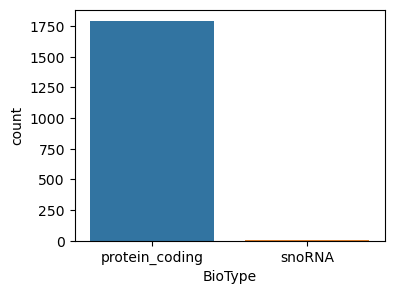

Counts:


protein_coding    1795
snoRNA               3
Name: BioType, dtype: int64

In [25]:
plt.figure(figsize = (4,3))
sns.countplot(data=df_genes, x="BioType")
plt.show()

print("Counts:")
df_genes['BioType'].value_counts()

Распределение по транскриптам:


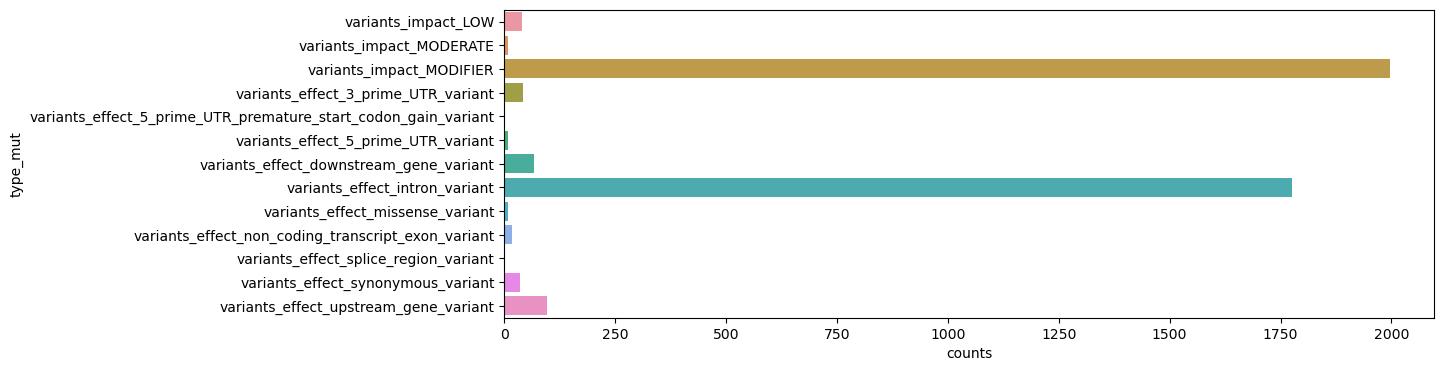

,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,variants_effect_5_prime_UTR_variant,variants_effect_downstream_gene_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_region_variant,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
counts,40,7,1997,42,2,8,66,1776,7,18,2,36,97
type_mut,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_co...,variants_effect_5_prime_UTR_variant,variants_effect_downstream_gene_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_var...,variants_effect_splice_region_variant,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant


In [26]:
print('Распределение по транскриптам:')

df_counts_types = pd.DataFrame((df_genes[df_genes.columns[4:]]!=0).sum(), columns = ['counts'])
df_counts_types['type_mut'] = df_counts_types.index

plt.figure(figsize = (12,4))
sns.barplot(data = df_counts_types, x = 'counts', y = 'type_mut')
plt.show()
df_counts_types.T

In [27]:
df_genes[df_genes['variants_effect_missense_variant']>0]

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,variants_effect_5_prime_UTR_variant,variants_effect_downstream_gene_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_region_variant,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
132,BLOC1S3,BLOC1S3,XM_030287335.3,protein_coding,0,3,0,0,0,0,0,0,3,0,0,0,0
309,CLEC14A,CLEC14A,XM_041716774.1,protein_coding,0,1,0,0,0,0,0,0,1,0,0,0,0
546,EPG5,EPG5,XM_041711037.1,protein_coding,0,1,0,0,0,0,0,0,1,0,0,0,0
547,EPG5,EPG5,XM_041711038.1,protein_coding,0,1,0,0,0,0,0,0,1,0,0,0,0
548,EPG5,EPG5,XM_041711039.1,protein_coding,0,1,0,0,0,0,0,0,1,0,0,0,0
549,EPG5,EPG5,XM_041711040.1,protein_coding,0,1,0,0,0,0,0,0,1,0,0,0,0
1603,RSRC2,RSRC2,XM_030286126.3,protein_coding,0,1,3,0,0,0,3,0,1,0,0,0,0
